<a href="https://colab.research.google.com/github/De-General10/Loan-Default-Prediction./blob/main/Predicting_Loan_Default_Risk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Phase 1: Data Preparation & Exploratory Data Analysis (EDA)**

This phase involves loading the three datasets, merging them, cleaning the data, and performing initial exploratory analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
df1 = pd.read_csv('pro_data_1.csv')
df2 = pd.read_csv('pro_data_2.csv')
df3 = pd.read_csv('pro_data_3.csv')

# --- Step 1: Data Merging ---
# Merge pro_data_1.csv and pro_data_2.csv
merged_df = pd.merge(df1, df2, on='customerid', how='left')

# Aggregate behavioral features from pro_data_3.csv
df3['approveddate'] = pd.to_datetime(df3['approveddate'])
df3['firstrepaiddate'] = pd.to_datetime(df3['firstrepaiddate'])
df3['days_to_repay'] = (df3['firstrepaiddate'] - df3['approveddate']).dt.days

behavioral_features = df3.groupby('customerid').agg(
    past_loans_count=('systemloanid', 'count'),
    avg_past_loan_amount=('loanamount', 'mean'),
    total_past_loan_amount=('loanamount', 'sum'),
    avg_days_to_repay=('days_to_repay', 'mean'),
).reset_index()

# Merge the behavioral features with the main DataFrame
df = pd.merge(merged_df, behavioral_features, on='customerid', how='left')

# --- Step 2: Data Cleaning & Feature Engineering ---
# Handle missing numerical values with the median
num_cols = ['avg_past_loan_amount', 'total_past_loan_amount', 'avg_days_to_repay', 'past_loans_count']
for col in num_cols:
    df[col].fillna(df[col].median(), inplace=True)

# Handle missing categorical values with 'Unknown'
cat_cols = ['employment_status_clients', 'level_of_education_clients', 'bank_account_type']
for col in cat_cols:
    df[col].fillna('Unknown', inplace=True)

# Create the 'Age' feature from 'birthdate'
df['birthdate'] = pd.to_datetime(df['birthdate'])
df['Age'] = (pd.to_datetime('now') - df['birthdate']).dt.days // 365
df['Age'].fillna(df['Age'].median(), inplace=True)

# Drop redundant or non-useful columns
df = df.drop(columns=['customerid', 'systemloanid', 'referredby', 'approveddate',
                      'creationdate', 'bank_branch_clients', 'birthdate'])

# Convert the target variable to numerical
df['good_bad_flag'] = df['good_bad_flag'].map({'Good': 0, 'Bad': 1})

# Handle categorical variables with one-hot encoding
df_final = pd.get_dummies(df, columns=['bank_account_type', 'bank_name_clients',
                                       'employment_status_clients', 'level_of_education_clients'],
                                       drop_first=True)

# Save the preprocessed data for the next phase
df_final.to_csv('preprocessed_data.csv', index=False)

print("Data preparation and merging complete. 'preprocessed_data.csv' saved.")

Data preparation and merging complete. 'preprocessed_data.csv' saved.


/tmp/ipython-input-3602276561.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipython-input-3602276561.py:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

**Phase 2: Model Training & Evaluation**.

This phase trains and evaluates three different machine learning models to predict loan default risk.

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:08:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Model Performance Comparison ---
                     Accuracy  Precision    Recall  F1-Score   ROC AUC
Logistic Regression  0.681402   0.356522  0.573427  0.439678  0.688763
Random Forest        0.789634   0.531646  0.293706  0.378378  0.681164
XGBoost              0.775915   0.479592  0.328671  0.390041  0.687796


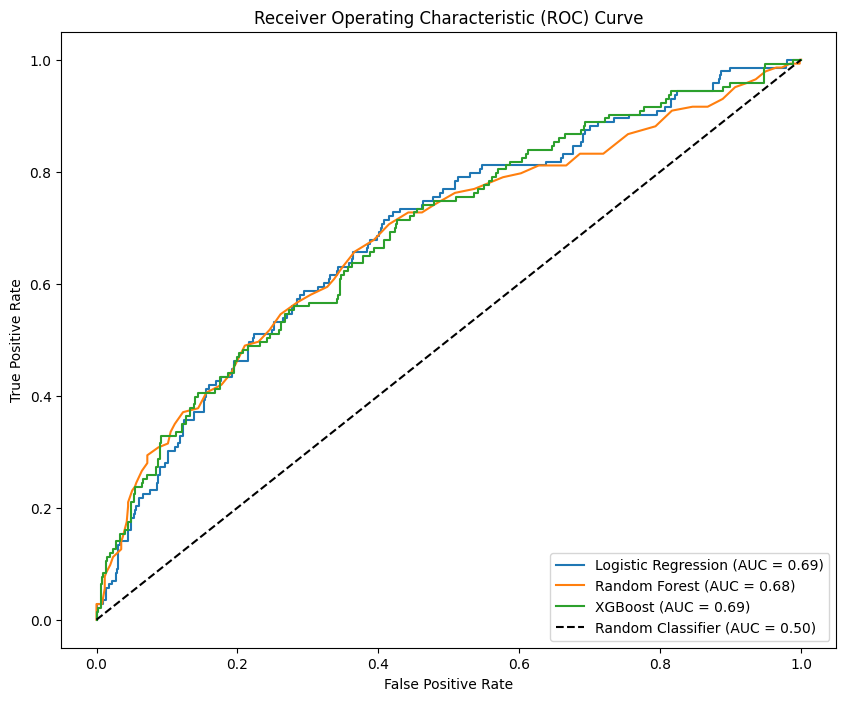


Best Model is likely XGBoost based on F1-Score and ROC AUC.


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# Load the preprocessed data
df = pd.read_csv('preprocessed_data.csv')

# Drop columns with missing values we did not handle, as they are not needed for this analysis
df = df.dropna()

# 1. Prepare data for modeling
X = df.drop('good_bad_flag', axis=1) # Features
y = df['good_bad_flag'] # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 2. Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Dictionary to store model results
results = {}

# --- 3. Train and Evaluate Models ---
# a) Logistic Regression (Baseline Model)
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_resampled, y_train_resampled)
y_pred_lr = lr_model.predict(X_test)
y_prob_lr = lr_model.predict_proba(X_test)[:, 1]
results['Logistic Regression'] = {
    'Accuracy': accuracy_score(y_test, y_pred_lr),
    'Precision': precision_score(y_test, y_pred_lr),
    'Recall': recall_score(y_test, y_pred_lr),
    'F1-Score': f1_score(y_test, y_pred_lr),
    'ROC AUC': roc_auc_score(y_test, y_prob_lr)
}

# b) Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]
results['Random Forest'] = {
    'Accuracy': accuracy_score(y_test, y_pred_rf),
    'Precision': precision_score(y_test, y_pred_rf),
    'Recall': recall_score(y_test, y_pred_rf),
    'F1-Score': f1_score(y_test, y_pred_rf),
    'ROC AUC': roc_auc_score(y_test, y_prob_rf)
}

# c) XGBoost Classifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_resampled, y_train_resampled)
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]
results['XGBoost'] = {
    'Accuracy': accuracy_score(y_test, y_pred_xgb),
    'Precision': precision_score(y_test, y_pred_xgb),
    'Recall': recall_score(y_test, y_pred_xgb),
    'F1-Score': f1_score(y_test, y_pred_xgb),
    'ROC AUC': roc_auc_score(y_test, y_prob_xgb)
}

# --- 4. Final Comparison & Visualization ---
# Convert results to a DataFrame for easy viewing
results_df = pd.DataFrame(results).T
print("\n--- Model Performance Comparison ---")
print(results_df)

# Visualize ROC curves
plt.figure(figsize=(10, 8))
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {results['Logistic Regression']['ROC AUC']:.2f})")
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {results['Random Forest']['ROC AUC']:.2f})")
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {results['XGBoost']['ROC AUC']:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

print("\nBest Model is likely XGBoost based on F1-Score and ROC AUC.")

**Phase 3: Unlocking Actionable Insights (SHAP)**.

This final phase focuses on interpreting the best-performing model (XGBoost) to understand which features are most important for predicting loan default. This is where one gets actionable insights for the business.

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:11:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Visualizing Feature Importance with SHAP ---


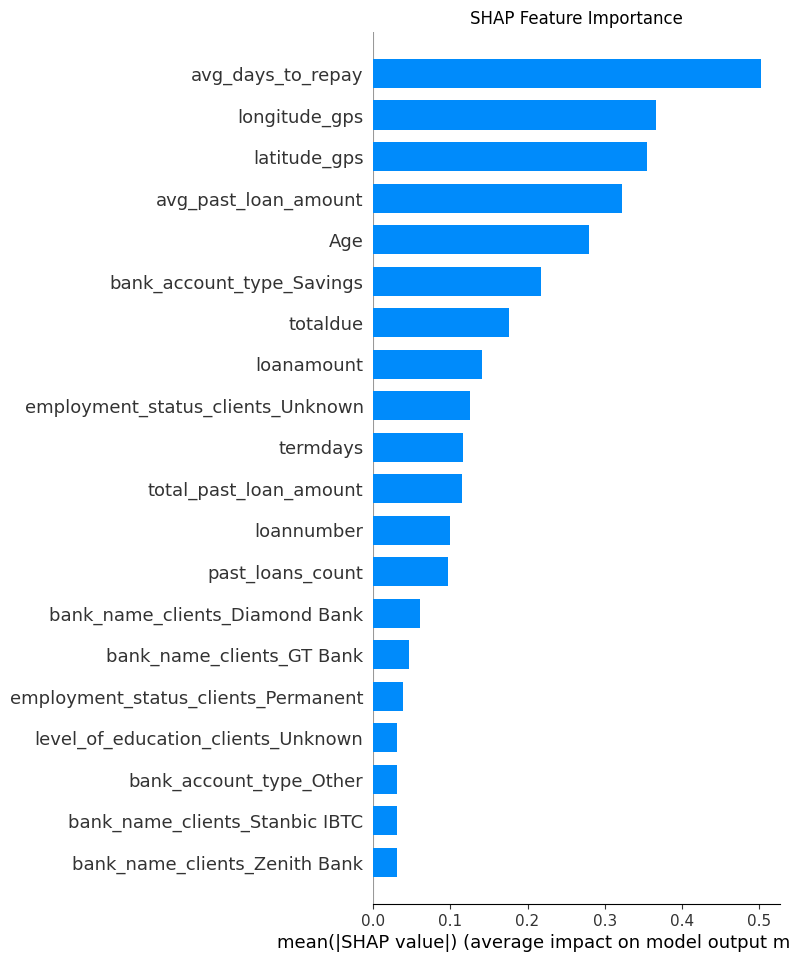

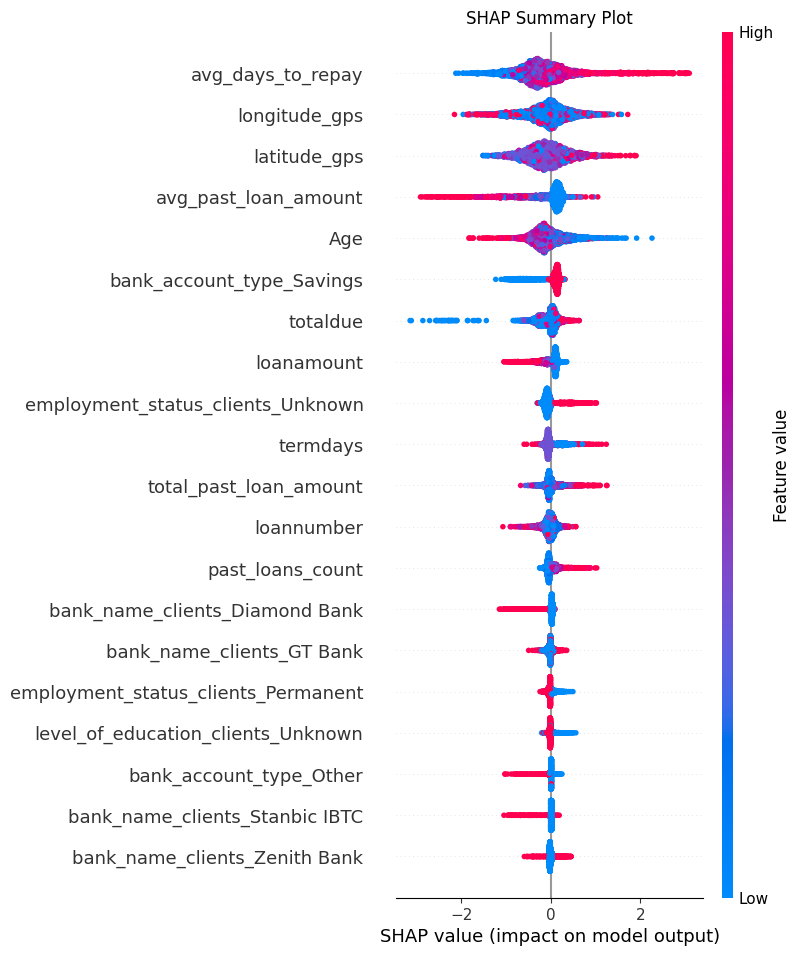


--- SHAP Values Head ---
   loannumber  loanamount  totaldue  termdays  longitude_gps  latitude_gps  \
0    0.130498   -0.090106  0.049387 -0.135817       0.475906      0.221283   
1   -0.067400   -0.129733 -0.091339 -0.047573      -0.106440      0.456632   
2   -0.066060    0.115614  0.037125 -0.024492      -1.380004      0.345554   
3   -0.033494    0.118802 -0.058175  0.340201      -0.213742     -0.111036   
4   -0.099112   -0.489709  0.301580 -0.153004      -0.813247     -0.233993   

   past_loans_count  avg_past_loan_amount  total_past_loan_amount  \
0          0.709453             -0.601365                0.348770   
1         -0.048196              0.235119                0.014692   
2          0.115246              0.177767               -0.247098   
3         -0.051707              0.240513                0.018601   
4          0.178791             -1.000876                0.043895   

   avg_days_to_repay  ...  employment_status_clients_Permanent  \
0           0.118502  ..

In [3]:
import pandas as pd
import shap
import xgboost as xgb
import matplotlib.pyplot as plt

# Load the preprocessed data and the trained XGBoost model from the previous step
df = pd.read_csv('preprocessed_data.csv')
df = df.dropna()
X = df.drop('good_bad_flag', axis=1)
y = df['good_bad_flag']

# Retrain the XGBoost model on the full preprocessed data to generate SHAP values
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X, y)

# Explain the model's predictions using SHAP
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X)

# Visualize feature importance
print("\n--- Visualizing Feature Importance with SHAP ---")
shap.summary_plot(shap_values, X, plot_type="bar", show=False)
plt.title('SHAP Feature Importance')
plt.show()

# You can also visualize the impact of individual features
shap.summary_plot(shap_values, X, show=False)
plt.title('SHAP Summary Plot')
plt.show()

# Get a DataFrame of SHAP values for further analysis
shap_df = pd.DataFrame(shap_values, columns=X.columns)
print("\n--- SHAP Values Head ---")
print(shap_df.head())